# Identify Lung Cancer from CT-Scan images using Identity Block in ResNets

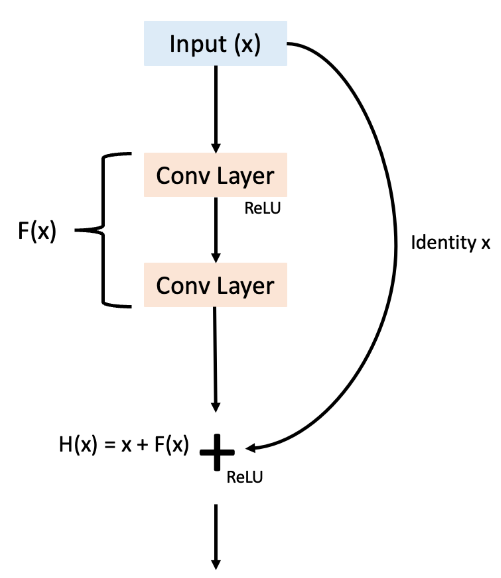

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten, BatchNormalization, Input
from tensorflow.keras.layers import Activation, AveragePooling2D, Concatenate, Add, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import  ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks  import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import os
import warnings
warnings.filterwarnings('ignore')

2024-08-19 22:37:32.941616: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-19 22:37:32.941765: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-19 22:37:33.069973: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Configuration
image_height, image_width = 224, 224
batch_size = 32
epochs = 20

### Dataset paths

In [3]:
train_dir = "/kaggle/input/chest-ctscan-images/Data/train/"
val_dir = "/kaggle/input/chest-ctscan-images/Data/test/"
test_dir = "/kaggle/input/chest-ctscan-images/Data/valid/"

### Data Augmentation

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Rescale the pixel values
    rotation_range=40,  # Rotate images by up to 40 degrees
    width_shift_range=0.3,  # Shift the image width by up to 30% of the image width
    height_shift_range=0.3,  # Shift the image height by up to 30% of the image height
    shear_range=0.3,  # Shear the image by up to 30%
    zoom_range=0.3,  # Zoom in/out by up to 30%
    horizontal_flip=True,  # Randomly flip images horizontally
    vertical_flip=True,  # Randomly flip images vertically
    brightness_range=[0.8, 1.2],  # Adjust the brightness randomly within this range
    channel_shift_range=0.2,  # Randomly shift the color channels
    fill_mode='nearest',  # How to fill in newly created pixels, nearest replicates the nearest pixel
    preprocessing_function=None  # You can add a custom function here for even more complex augmentations
)

validation_datagen = ImageDataGenerator(rescale=1./255)

In [5]:
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode="categorical"
)

validation_data = validation_datagen.flow_from_directory(
    val_dir,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode="categorical"
)

Found 613 images belonging to 4 classes.
Found 315 images belonging to 4 classes.


In [6]:
# Test Data Generator
test_datagen = ImageDataGenerator(rescale=1./255)

# Load the test data
test_data = test_datagen.flow_from_directory(
    test_dir,  # Directory with test images
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False  # Important to set shuffle to False for testing
)

Found 72 images belonging to 4 classes.


In [7]:
# Identity Block
def identity_block(input_tensor, kernel_size, filters):
    filters1, filters2, filters3 = filters
    x = Conv2D(filters1, (1, 1), padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters2, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters3, (1, 1), padding='same')(x)
    x = BatchNormalization()(x)
    x = Add()([x, input_tensor])
    x = Activation('relu')(x)
    return x

In [8]:
# Convolutional Block
def conv_block(input_tensor, kernel_size, filters, strides=(2, 2)):
    filters1, filters2, filters3 = filters
    x = Conv2D(filters1, (1, 1), strides=strides)(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters2, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters3, (1, 1), padding='same')(x)
    x = BatchNormalization()(x)
    shortcut = Conv2D(filters3, (1, 1), strides=strides)(input_tensor)
    shortcut = BatchNormalization()(shortcut)
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

In [9]:
# ResNet-Like Model with Identity Blocks
def reuse_learning(input_shape=(224, 224, 3), include_top=False):
    img_input = Input(shape=input_shape)
    x = Conv2D(64, (7, 7), strides=(2, 2), padding='same')(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    x = conv_block(x, 3, [64, 64, 256], strides=(1, 1))
    for _ in range(2):
        x = identity_block(x, 3, [64, 64, 256])

    x = conv_block(x, 3, [128, 128, 512])
    for _ in range(3):
        x = identity_block(x, 3, [128, 128, 512])

    x = conv_block(x, 3, [256, 256, 1024])
    for _ in range(5):
        x = identity_block(x, 3, [256, 256, 1024])

    x = conv_block(x, 3, [512, 512, 2048])
    for _ in range(2):
        x = identity_block(x, 3, [512, 512, 2048])

    if include_top:
        x = GlobalAveragePooling2D()(x)
        x = Dense(1000, activation='relu')(x)
        x = Dropout(0.5)(x)
        x = Dense(4, activation='softmax')(x)

    model = Model(inputs=img_input, outputs=x)
    return model

In [10]:
def chest_custom_model1(input_shape=(224, 224, 3)):
    base_resnet = reuse_learning(input_shape, include_top=False)
    
    for layer in base_resnet.layers[:150]:  
        layer.trainable = False
    
    inputs = Input(shape=input_shape)
    x = base_resnet(inputs)
    
    # Apply Global Average Pooling to match the dimensions
    x = GlobalAveragePooling2D()(x)
    
    # Add fully connected layers with L2 regularization
    x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.5)(x)
    
    # Final output layer with L2 regularization
    output = Dense(4, activation='softmax', kernel_regularizer=l2(0.01))(x)
    
    # Define the model
    model = Model(inputs=inputs, outputs=output)
    return model

In [11]:
from tensorflow.keras.layers import Concatenate, Flatten, Dense, Dropout, Input
from tensorflow.keras.models import Model

def fuse_models(resnet_model, chest_custom_model1, input_shape=(224, 224, 3)):
    input_layer = Input(shape=input_shape)

    # Extract features from both models
    features1 = resnet_model(input_layer)
    features2 = chest_custom_model1(input_layer)

    # Flatten the features to make them compatible
    flattened_features1 = Flatten()(features1)
    flattened_features2 = Flatten()(features2)

    # Concatenate flattened features
    combined_features = Concatenate()([flattened_features1, flattened_features2])

    # Add fully connected layers after concatenation
    x = Dense(1024, activation='relu')(combined_features)
    x = Dropout(0.5)(x)
    output = Dense(4, activation='softmax')(x)

    # Define the model
    model = Model(inputs=input_layer, outputs=output)
    return model

#### Learning Rate Warmup
Gradual Increase: Start with a very low learning rate and gradually increase it to the desired level. This can sometimes lead to better convergence.

In [12]:
from tensorflow.keras.callbacks import LearningRateScheduler

def lr_schedule(epoch):
    initial_lr = 1e-5
    final_lr = 1e-3
    epochs_ramp_up = 10
    lr = initial_lr + (final_lr - initial_lr) * (epoch / epochs_ramp_up)
    return min(lr, final_lr)

lr_scheduler = LearningRateScheduler(lr_schedule)


In [13]:
from tensorflow.keras.optimizers import Adam

# Define model1 using the reuse_learning function
model1 = reuse_learning(input_shape=(224, 224, 3), include_top=False)

# Define model2 using the chest_custom_model1 function
model2 = chest_custom_model1(input_shape=(224, 224, 3))

# Fuse both models using the fuse_models function
model = fuse_models(model1, model2)

# Compile the model with the specified optimizer, loss, and metrics
optimizer = Adam(learning_rate=1e-6)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


In [14]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-4)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min')
lr_scheduler = LearningRateScheduler(lr_schedule)

### Train the model

In [15]:
history = model.fit(
    train_data,
    epochs=epochs,
    validation_data=validation_data,
    callbacks=[early_stopping, model_checkpoint, reduce_lr,lr_scheduler]
)

Epoch 1/20


I0000 00:00:1724107161.065450      94 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1724107161.173795      94 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724107161.203103      94 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 1/20 ━━━━━━━━━━━━━━━━━━━━ 29:11 92s/step - accuracy: 0.2000 - loss: 18.2522

W0000 00:00:1724107216.232663      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724107216.261591      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3894 - loss: 16.7924

W0000 00:00:1724107235.560533      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724107235.586493      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724107247.966639      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724107247.992972      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


20/20 ━━━━━━━━━━━━━━━━━━━━ 196s 5s/step - accuracy: 0.3918 - loss: 16.7667 - val_accuracy: 0.3810 - val_loss: 14.9475 - learning_rate: 1.0000e-05
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.3655 - loss: 19.4724 - val_accuracy: 0.2857 - val_loss: 13.2622 - learning_rate: 1.0900e-04
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.3945 - loss: 13.9956 - val_accuracy: 0.2857 - val_loss: 10.1566 - learning_rate: 2.0800e-04
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.4442 - loss: 9.5902 - val_accuracy: 0.3810 - val_loss: 7.0678 - learning_rate: 3.0700e-04
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.4428 - loss: 6.2647 - val_accuracy: 0.2857 - val_loss: 4.7345 - learning_rate: 4.0600e-04
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.4493 - loss: 3.7331 - val_accuracy: 0.3810 - val_loss: 2.9834 - learning_rate: 5.0500e-04
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.4918 - loss: 2.2

In [16]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_data)

# Print the test accuracy
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step - accuracy: 0.4293 - loss: 1.5453
Test Accuracy: 31.94%


W0000 00:00:1724107573.119760      94 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724107573.147378      94 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step

W0000 00:00:1724107581.330602      94 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724107581.358769      94 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


3/3 ━━━━━━━━━━━━━━━━━━━━ 14s 4s/step


W0000 00:00:1724107588.743217      94 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724107588.771012      94 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.4293 - loss: 1.5453
Test Accuracy: 31.94%


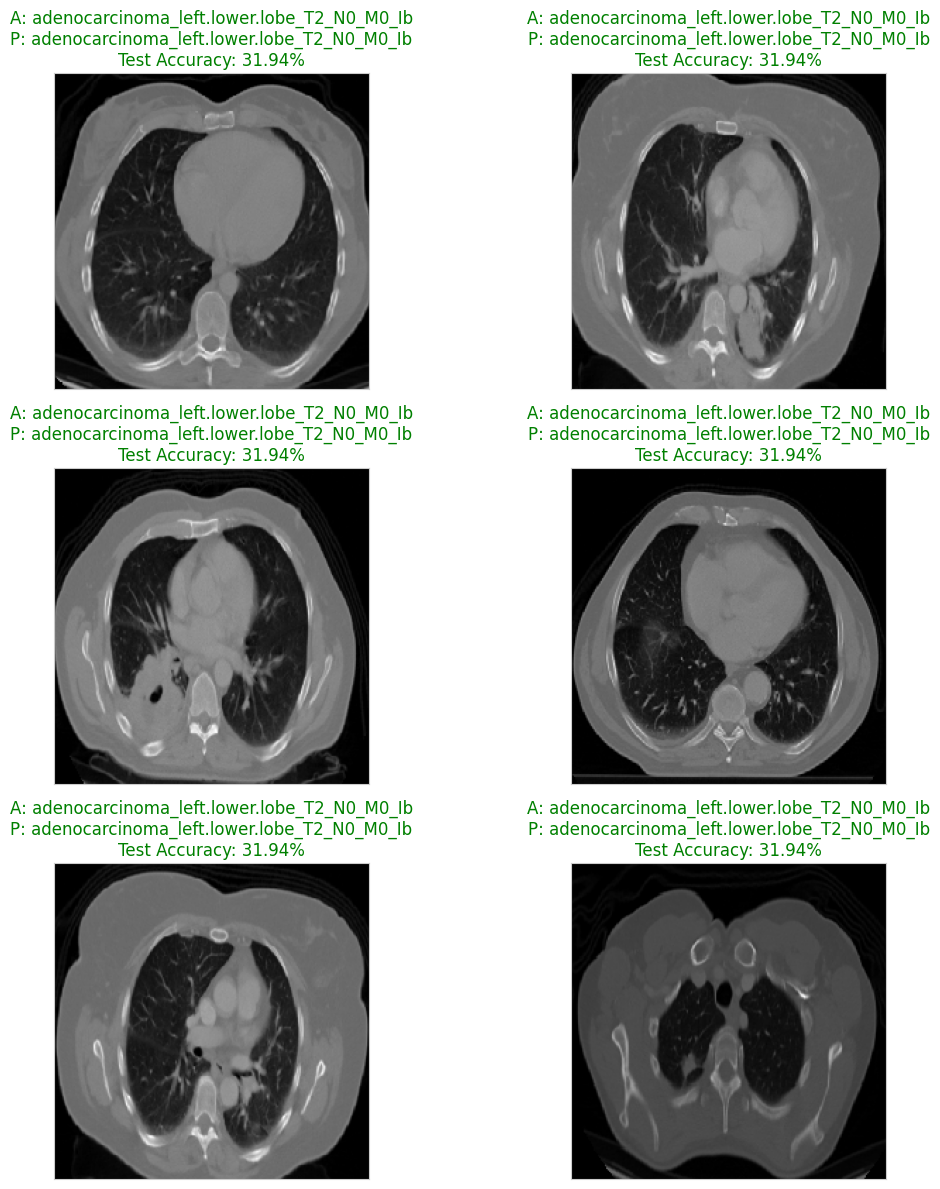

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_style("whitegrid")

# Predicting on test data
predictions = model.predict(test_data)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_data.classes
class_labels = list(test_data.class_indices.keys())

# Get the accuracy on test data
test_loss, test_accuracy = model.evaluate(test_data)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Plot some test images with their predictions
plt.figure(figsize=(12, 12))
for i in range(6):
    plt.subplot(3, 2, i+1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    # Display image
    img = test_data[0][0][i]
    plt.imshow(img)
    
    # Actual label
    actual_label = class_labels[true_classes[i]]
    
    # Predicted label
    predicted_label = class_labels[predicted_classes[i]]
    
    # Title with actual and predicted labels
    title = f"A: {actual_label}\nP: {predicted_label}\nTest Accuracy: {test_accuracy * 100:.2f}%"
    
    # Check if prediction is correct
    correct = predicted_label == actual_label
    color = "green" if correct else "red"
    
    plt.title(title, color=color)

plt.tight_layout()
plt.show()
